# **Imports & Configuration**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Sklearn modules for preprocessing and modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuration to make output readable
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# **Load Data**

In [ ]:
file_path = 'WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv'

try:
    df = pd.read_csv(file_path)
    print("Data loaded successfully!")
    print(f"Dataset Shape: {df.shape}") # Shows (Rows, Columns)
except FileNotFoundError:
    print("Error: File not found. Please upload the CSV file to Colab.")

# Standardize column names (replace spaces with underscores, lowercase)
# This makes coding much easier (e.g., 'Customer Lifetime Value' becomes 'customer_lifetime_value')
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Display first 5 rows
df.head()

Data loaded successfully!
Dataset Shape: (9134, 24)


,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,income,location_code,marital_status,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


## **Target Distribution**

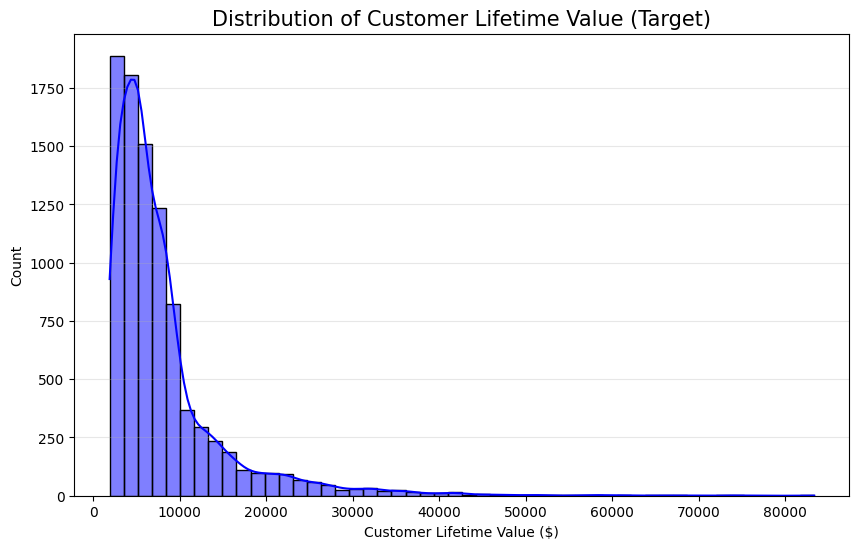

In [ ]:


plt.figure(figsize=(10, 6))
# Histogram with a Kernel Density Estimate (KDE) line
sns.histplot(df['customer_lifetime_value'], kde=True, color='blue', bins=50)

plt.title('Distribution of Customer Lifetime Value (Target)', fontsize=15)
plt.xlabel('Customer Lifetime Value ($)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.show()

***Interpretation :***
* La variable cible présente une forte asymétrie positive, typique des
données financières. Cela confirme la nécessité d'utiliser des modèles robustes non-paramétriques (comme Random Forest) et démontre l'importance cruciale de quantifier l'incertitude pour les valeurs élevées, qui sont rares mais critiques

## **Correlation Heatmap**

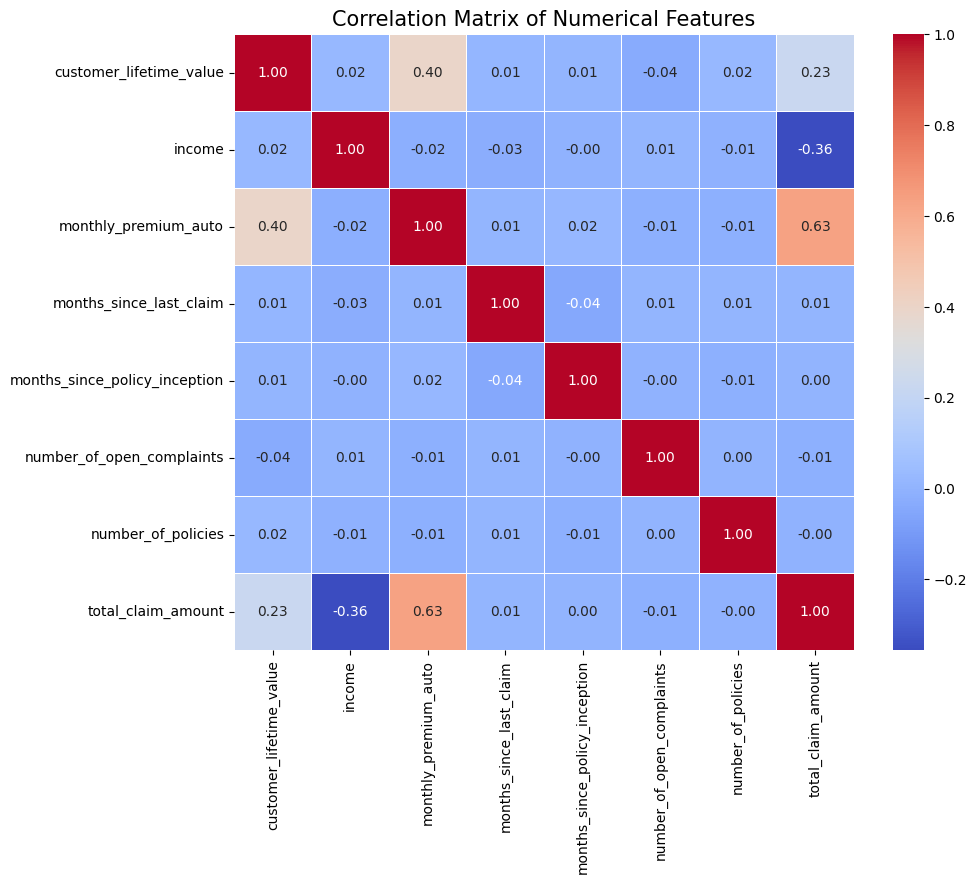

In [ ]:
plt.figure(figsize=(10, 8))

# Select only numerical columns for correlation
numerical_df = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numerical_df.corr()

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Matrix of Numerical Features', fontsize=15)
plt.show()

***Interpretation :***
* Les faibles corrélations linéaires globales confirment que le problème est complexe et justifient l'utilisation d'algorithmes non-linéaires comme le Random Forest. La variable monthly_premium_auto semble être le facteur déterminant parmi les données numériques.

## **Categorical Feature Impact (Boxplots)**

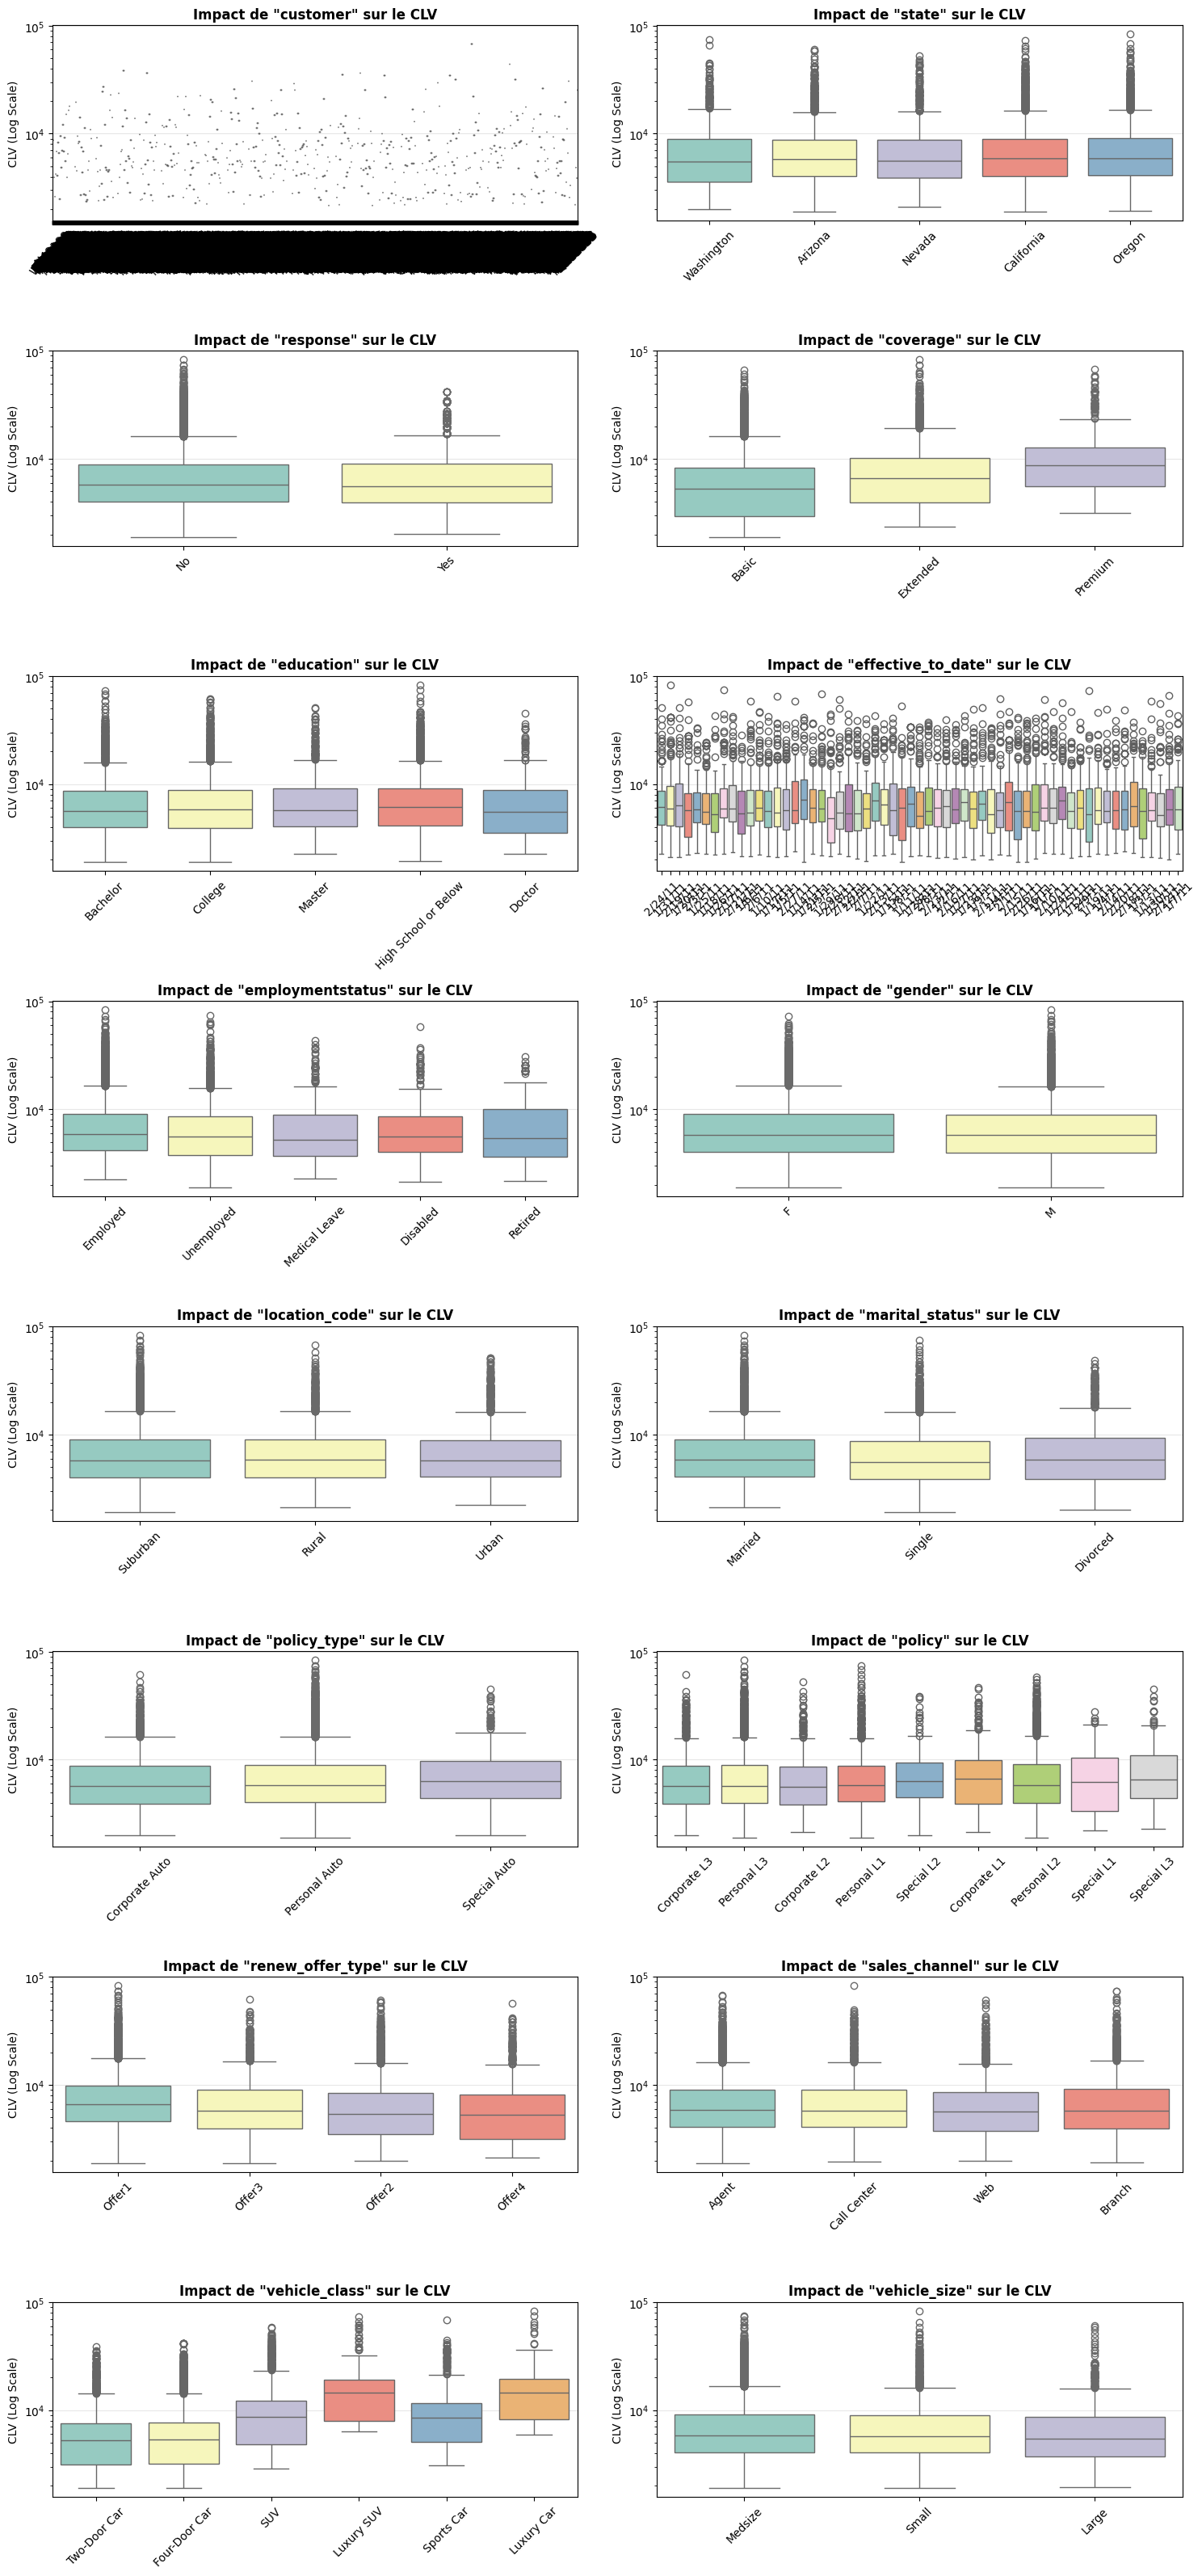

In [ ]:


# 1. Identifier les colonnes catégorielles (excluant la cible et les dates)
# On récupère toutes les colonnes de type 'object' (texte)
categorical_cols = df.select_dtypes(include=['object']).columns

# Calculate the number of rows needed for the subplots
num_categorical_cols = len(categorical_cols)
nrows = (num_categorical_cols + 1) // 2 # +1 for ceiling division for two columns

# 2. Configuration de la taille des graphiques
plt.figure(figsize=(15, nrows * 4)) # Adjust figure height based on number of rows

# 3. Boucle pour créer un graphique par variable
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(nrows, 2, i) # Adjust grid dimensions dynamically

    # Création du Boxplot
    sns.boxplot(x=col, y='customer_lifetime_value', data=df, palette='Set3')

    plt.title(f'Impact de "{col}" sur le CLV', fontsize=12, fontweight='bold')
    plt.xlabel('') # On enlève le label X pour alléger
    plt.ylabel('CLV (Log Scale)')

    # Échelle logarithmique indispensable car vos données sont très étendues (skewed)
    plt.yscale('log')

    # Rotation des étiquettes si elles sont trop longues (ex: vehicle_class)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)

plt.tight_layout() # Ajuste automatiquement les espacements pour que ce soit joli
plt.show()


***Interpretation :***
1.  Les Variables à Fort Impact

Ces variables montrent des différences nettes de niveau médian (les traits noirs au milieu des boîtes ne sont pas au même niveau).

* coverage (Couverture) :

Observation : On voit un effet "escalier" très net. Basic < Extended < Premium.

Interprétation : C'est un prédicteur majeur. Plus la couverture est haute gamme, plus la valeur du client est élevée. Logique et crucial pour le modèle.

* vehicle_class (Classe de Véhicule) :

Observation : Regardez les catégories Luxury SUV et Luxury Car. Leurs boîtes sont situées beaucoup plus haut sur l'axe Y que Two-Door Car ou Four-Door Car.

Interprétation : C'est probablement votre variable la plus discriminante. Posséder une voiture de luxe multiplie la valeur du client.

* employmentstatus (Statut d'emploi) :

Observation : Les chômeurs (Unemployed) ont une médiane plus basse que les employés (Employed).

Interprétation : Le statut social influence la valeur (probablement lié au pouvoir d'achat).

* renew_offer_type (Type d'offre de renouvellement) :

Observation : L'Offer1 et l'Offer2 semblent attirer des clients à valeurs différentes par rapport à l'Offer3 ou 4. Il y a une variation visible.

2. Les Variables à Faible Impact (Le "Bruit")
Ces variables ont des boîtes quasi identiques. Elles n'aideront pas beaucoup le modèle à distinguer un client "cher" d'un client "moyen".

* gender (Genre) :

Observation : Les boîtes F (Femme) et M (Homme) sont des jumelles parfaites.

Interprétation : Le genre n'a aucune influence sur la valeur du client dans ce jeu de données. Le modèle ne l'utilisera probablement pas.

* state (État) :

Observation : Que le client soit en Arizona, Oregon ou Californie, la distribution du CLV est la même.

Interprétation : La géographie (à ce niveau de granularité) ne semble pas être un facteur déterminant.

* marital_status (Statut Marital) :

Observation : Très peu de différence entre Married, Single et Divorced.

* customer :

Observation : C'est le premier graphique (nuage de points noir). C'est juste du bruit, ce qui confirme qu'il faut supprimer cette colonne (c'est l'ID unique).

# **Nettoyage et Feature Engineering**

In [ ]:
# 1. Recharger proprement les données
df_clean = df.copy()

# 2. Gestion des Dates (Feature Engineering)
# Au lieu de supprimer la date, on extrait le mois, car il peut y avoir une saisonnalité.
df_clean['effective_to_date'] = pd.to_datetime(df_clean['effective_to_date'])
df_clean['policy_month'] = df_clean['effective_to_date'].dt.month

# Maintenant on peut supprimer la date originale et l'ID client qui ne servent plus
cols_to_drop = ['customer', 'effective_to_date']
df_clean = df_clean.drop(columns=cols_to_drop)

In [ ]:
# 3. Suppression des doublons (S'il y en a)
# Des doublons faussent l'évaluation du modèle
initial_rows = df_clean.shape[0]
df_clean = df_clean.drop_duplicates()
print(f"Lignes supprimées (doublons) : {initial_rows - df_clean.shape[0]}")

Lignes supprimées (doublons) : 163


In [ ]:
# 4. Traitement de la Variable Cible (Log-Transformation)
#  Comme vu dans la visualisation, la cible est très asymétrique (skewed).
# Les modèles apprennent mieux si on prédit le Logarithme de la valeur, plutôt que la valeur brute.
# Nous allons créer une colonne cible transformée.
df_clean['log_CLV'] = np.log1p(df_clean['customer_lifetime_value'])

print("Nettoyage terminé. Aperçu des nouvelles colonnes :")
df_clean[['policy_month', 'log_CLV']].head()

Nettoyage terminé. Aperçu des nouvelles colonnes :


,policy_month,log_CLV
0,2,7.924622
1,1,8.850881
2,2,9.464085
3,1,8.942051
4,2,7.942608


In [ ]:
null_counts = df_clean.isnull().sum()
null_counts = null_counts[null_counts > 0]

if null_counts.empty:
    print(" Aucune valeur manquante détectée dans le dataset !")

 Aucune valeur manquante détectée dans le dataset !


# **Encodage (One-Hot Encoding)**

In [ ]:
# 1. Définir X (Variables) et y (Cible)
# ATTENTION : On enlève la cible originale ET la cible log (pour ne pas tricher)
target_col = 'customer_lifetime_value' # On garde l'originale pour l'évaluation finale
log_target_col = 'log_CLV'             # On utilisera celle-ci pour l'entraînement (meilleure performance)

X = df_clean.drop([target_col, log_target_col], axis=1)
y = df_clean[target_col]      # Valeurs réelles (ex: 5000$)
y_log = df_clean[log_target_col] # Valeurs Log (ex: 8.5)

# 2. Encodage des variables catégorielles (One-Hot Encoding)
# drop_first=True évite la multicolinéarité parfaite (bon pour la stabilité)
X_encoded = pd.get_dummies(X, drop_first=True)

print(f"Dimensions après encodage : {X_encoded.shape}")
print(X_encoded.columns[:].tolist())

Dimensions après encodage : (8971, 51)
['income', 'monthly_premium_auto', 'months_since_last_claim', 'months_since_policy_inception', 'number_of_open_complaints', 'number_of_policies', 'total_claim_amount', 'policy_month', 'state_California', 'state_Nevada', 'state_Oregon', 'state_Washington', 'response_Yes', 'coverage_Extended', 'coverage_Premium', 'education_College', 'education_Doctor', 'education_High School or Below', 'education_Master', 'employmentstatus_Employed', 'employmentstatus_Medical Leave', 'employmentstatus_Retired', 'employmentstatus_Unemployed', 'gender_M', 'location_code_Suburban', 'location_code_Urban', 'marital_status_Married', 'marital_status_Single', 'policy_type_Personal Auto', 'policy_type_Special Auto', 'policy_Corporate L2', 'policy_Corporate L3', 'policy_Personal L1', 'policy_Personal L2', 'policy_Personal L3', 'policy_Special L1', 'policy_Special L2', 'policy_Special L3', 'renew_offer_type_Offer2', 'renew_offer_type_Offer3', 'renew_offer_type_Offer4', 'sales

# **La Découpe Stratégique (Train / Calib / Test)**

In [ ]:

from sklearn.model_selection import train_test_split

# On a besoin de 3 ensembles :
# 1. Train (60%) : Pour apprendre
# 2. Calibration (20%) : Pour calculer les intervalles (Composante 2 du projet)
# 3. Test (20%) : Pour vérifier la couverture (Composante 3 du projet)

# Premier split : On sépare Train (60%) du reste (40%)
# On utilise y_log pour stratifier si possible, sinon random simple
X_train, X_temp, y_train_log, y_temp_log, y_train_real, y_temp_real = train_test_split(
    X_encoded, y_log, y, test_size=0.4, random_state=42
)

# Second split : On coupe le reste en deux (20% Calib, 20% Test)
X_calib, X_test, y_calib_log, y_test_log, y_calib_real, y_test_real = train_test_split(
    X_temp, y_temp_log, y_temp_real, test_size=0.5, random_state=42
)

print(f"--- Résumé des Dimensions ---")
print(f"Entraînement (Train) : {X_train.shape} lignes")
print(f"Calibration (Calib)  : {X_calib.shape} lignes")
print(f"Test Final (Test)    : {X_test.shape} lignes")

print("\nLa variable 'y_train_log' sera utilisée pour entraîner le modèle.")
print("La variable 'y_test_real' sera utilisée pour vérifier les erreurs en dollars.")

--- Résumé des Dimensions ---
Entraînement (Train) : (5382, 51) lignes
Calibration (Calib)  : (1794, 51) lignes
Test Final (Test)    : (1795, 51) lignes

La variable 'y_train_log' sera utilisée pour entraîner le modèle.
La variable 'y_test_real' sera utilisée pour vérifier les erreurs en dollars.


# **Entraînement et Évaluation du Modèle**

In [ ]:
# 1. Configuration et Entraînement
print("🚀 Démarrage de l'entraînement du Random Forest...")

# n_estimators=200 : On utilise 200 arbres pour une meilleure précision
# n_jobs=-1 : Utilise tous les cœurs du processeur pour aller plus vite
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

# On entraîne sur X_train et y_train_log (l'échelle logarithmique)
rf_model.fit(X_train, y_train_log)

print("✅ Modèle entraîné avec succès !")

🚀 Démarrage de l'entraînement du Random Forest...
✅ Modèle entraîné avec succès !


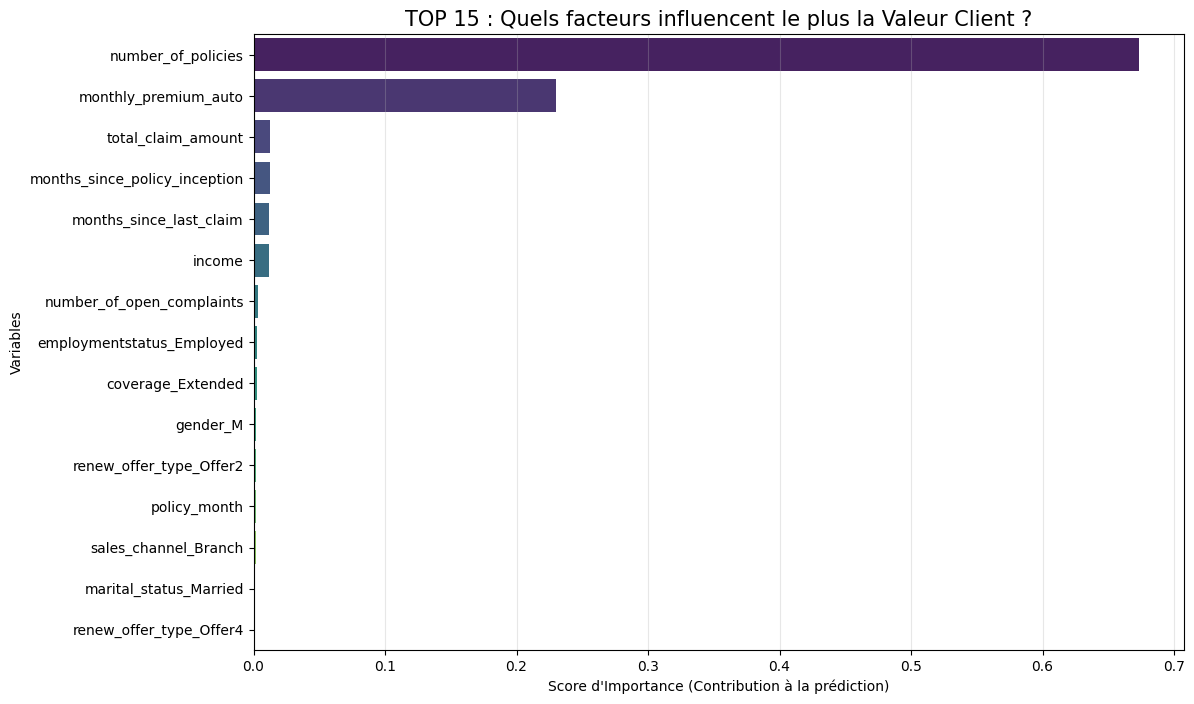

In [ ]:
# --- CELLULE : Visualisation de l'Importance des Variables ---

# 1. Récupération des données d'importance
# Le modèle a calculé un score pour chaque colonne pendant l'entraînement
importances = rf_model.feature_importances_
feature_names = X_train.columns

# 2. Création d'un DataFrame pour trier proprement
# On associe chaque nom de colonne à son score
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 3. Tri et Sélection du Top 15
# On veut voir les plus grands scores en premier
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(15)

# 4. Création du Graphique
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')

plt.title('TOP 15 : Quels facteurs influencent le plus la Valeur Client ?', fontsize=15)
plt.xlabel('Score d\'Importance (Contribution à la prédiction)')
plt.ylabel('Variables')
plt.grid(axis='x', alpha=0.3)
plt.show()

In [ ]:
# 2. Prédiction sur l'ensemble de TEST (pour l'évaluation finale)
print("🔍 Calcul des prédictions sur le Test Set...")
preds_log = rf_model.predict(X_test)

# 3. IMPORTANT : Retransformation en Dollars
# Le modèle a prédit des Logs, on remet ça en Dollars avec exp()
preds_dollar = np.expm1(preds_log)

# 4. Calcul des Scores de Performance (Comparaison avec la réalité)
r2 = r2_score(y_test_real, preds_dollar)
mae = mean_absolute_error(y_test_real, preds_dollar)
rmse = np.sqrt(mean_squared_error(y_test_real, preds_dollar))

print("\n" + "="*40)
print("📊 RÉSULTATS DE PERFORMANCE (En Dollars)")
print("="*40)
print(f"R² Score (Précision globale) : {r2:.4f}  (Idéalement > 0.60)")
print(f"MAE (Erreur Moyenne)         : {mae:.2f} $")
print(f"RMSE (Pénalise les gros écarts): {rmse:.2f} $")
print("="*40)

🔍 Calcul des prédictions sur le Test Set...

📊 RÉSULTATS DE PERFORMANCE (En Dollars)
R² Score (Précision globale) : 0.6774  (Idéalement > 0.60)
MAE (Erreur Moyenne)         : 1428.22 $
RMSE (Pénalise les gros écarts): 3848.59 $


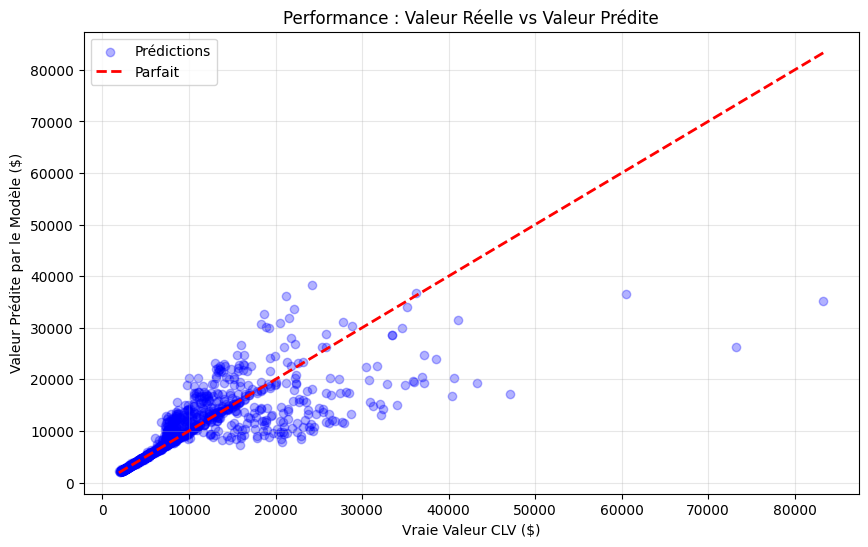

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_real, preds_dollar, alpha=0.3, color='blue', label='Prédictions')
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--', lw=2, label='Parfait')

plt.title('Performance : Valeur Réelle vs Valeur Prédite')
plt.xlabel('Vraie Valeur CLV ($)')
plt.ylabel('Valeur Prédite par le Modèle ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# **Inférence Statistique & Quantification de l'Incertitude**

**Objectif :** Dans cette section, nous dépassons la simple prédiction ponctuelle pour fournir une mesure de la fiabilité du modèle. En utilisant le **set de calibration**, nous analysons les erreurs du modèle pour construire des **Intervalles de Prédiction (IP)** à $95\%$.

Cela permet à l'assureur de comprendre non seulement la valeur attendue d'un client, mais aussi le risque associé à cette estimation.

### **1. Analyse de la distribution empirique des résidus**

Avant de construire les intervalles, nous devons étudier la manière dont le modèle commet des erreurs. Étant donné que nous avons entraîné le modèle sur une échelle logarithmique $\log(1+x)$, les résidus sont calculés dans cet espace pour stabiliser la variance (homoscédasticité).

> **Note théorique :** Le résidu $e$ est défini par l'équation suivante :
> $$e = y_{\text{réel}} - \hat{y}_{\text{prédit}}$$
>
> Si le modèle est parfaitement calibré, la moyenne des résidus $\bar{e}$ doit être statistiquement proche de $0$.

Statistiques des résidus (log_CLV) :
 - Moyenne : -0.0005
 - Skewness (Asymétrie) : 1.41


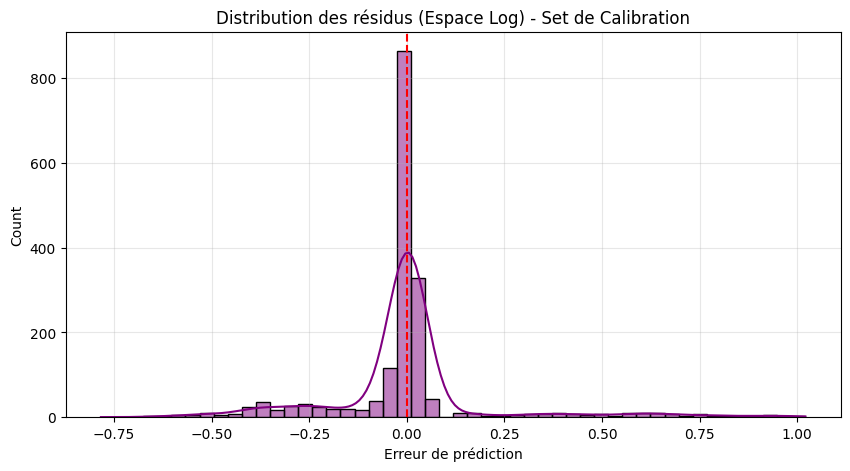

In [ ]:
# --- Prédictions sur l'ensemble de calibration ---
y_pred_calib_log = rf_model.predict(X_calib)

# Retour à l’échelle réelle ($) pour comparaison
y_pred_calib_dollars = np.expm1(y_pred_calib_log)
y_calib_dollars = np.expm1(y_calib_log)

# Calcul des résidus dans l'espace log
residus_log = y_calib_log.values - y_pred_calib_log

print(f"Statistiques des résidus (log_CLV) :")
print(f" - Moyenne : {residus_log.mean():.4f}")
print(f" - Skewness (Asymétrie) : {stats.skew(residus_log):.2f}")

# Visualisation de la distribution
plt.figure(figsize=(10, 5))
sns.histplot(residus_log, bins=50, kde=True, color="purple")
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution des résidus (Espace Log) - Set de Calibration")
plt.xlabel("Erreur de prédiction")
plt.grid(alpha=0.3)
plt.show()

> **Interprétation des résultats :**
> * **Centrage sur zéro :** La distribution des résidus est fortement concentrée autour de la ligne rouge ($0$).  Cela indique que le modèle n'a pas de biais systématique majeur (il ne surestime ni ne sous-estime globalement la CLV).
> * **Nature de la distribution :** Bien que centrée, on observe des "queues" de distribution. La présence de ces valeurs extrêmes confirme que l'erreur ne suit pas parfaitement une loi normale $\mathcal{N}(0, \sigma^2)$.
> * **Justification technique :** Cette observation valide notre choix d'utiliser des méthodes **non-paramétriques** (Quantiles et Bootstrap) pour définir les intervalles de prédiction, car elles sont plus robustes face aux écarts de normalité.

### **2. Méthode 1 : Intervalles par Quantiles Empiriques**

Cette approche est **non-paramétrique** : elle ne repose sur aucune supposition quant à la distribution de l'erreur (comme la normalité). Nous extrayons directement les centiles $2.5\%$ et $97.5\%$ de la distribution des résidus observés sur le set de calibration pour couvrir $95\%$ des cas.

L'intervalle de prédiction ($IP$) en dollars est ensuite reconstruit via la transformation inverse (exponentielle) pour revenir à l'échelle originale de la CLV :

$$IP = \left[ \exp(\hat{y} + q_{0.025}) - 1 \, , \, \exp(\hat{y} + q_{0.975}) - 1 \right]$$

Où :
* $\hat{y}$ est la prédiction du modèle dans l'espace logarithmique.
* $q_{0.025}$ et $q_{0.975}$ sont les quantiles de l'erreur calculés précédemment.

In [ ]:
# Calcul des quantiles 2.5% et 97.5%
q_lower = np.quantile(residus_log, 0.025)
q_upper = np.quantile(residus_log, 0.975)

print(f"Bornes d'erreur (Log) : [{q_lower:.4f}, {q_upper:.4f}]")

# Application aux prédictions
pi_lower_quantile = np.expm1(y_pred_calib_log + q_lower)
pi_upper_quantile = np.expm1(y_pred_calib_log + q_upper)

Bornes d'erreur (Log) : [-0.4152, 0.6410]


# **Méthode 2 : Inférence par Bootstrapping**

Le **Bootstrap** renforce la robustesse de l'estimation de l'incertitude en simulant $N = 1500$ fois le processus d'erreur. Au lieu de se baser sur une seule mesure statique, nous créons une distribution complète de prédictions possibles pour chaque client.

**Algorithme utilisé :**
1. Pour chaque simulation $b \in \{1, \dots, N\}$ :
   * Tirer un résidu $\epsilon^*$ aléatoirement avec remplacement dans le set de calibration.
   * Calculer la prédiction simulée : $\hat{y}_{sim}^{(b)} = \hat{y}_{log} + \epsilon^*$.
2. Transformer les résultats en dollars : $CLV_{sim}^{(b)} = \exp(\hat{y}_{sim}^{(b)}) - 1$.
3. Calculer les bornes $[2.5\% , 97.5\%]$ sur la distribution des $1500$ prédictions obtenues.

Cette méthode permet de capturer la variabilité du modèle de manière beaucoup plus dynamique.

In [ ]:
n_bootstrap = 1500
boot_preds_log = np.zeros((n_bootstrap, len(y_pred_calib_log)))

print(f"Lancement du Bootstrap ({n_bootstrap} itérations)...")

for i in range(n_bootstrap):
    # Rééchantillonnage des résidus avec remplacement
    boot_res = np.random.choice(residus_log, size=len(residus_log), replace=True)
    boot_preds_log[i] = y_pred_calib_log + boot_res

# Conversion massive en dollars
boot_preds_dollars = np.expm1(boot_preds_log)

# Extraction des intervalles
pi_lower_boot = np.percentile(boot_preds_dollars, 2.5, axis=0)
pi_upper_boot = np.percentile(boot_preds_dollars, 97.5, axis=0)

print(" Bootstrap terminé. Les intervalles de confiance sont calculés.")

Lancement du Bootstrap (1500 itérations)...
 Bootstrap terminé. Les intervalles de confiance sont calculés.


# **Validation Interne : Couverture et Précision**

Avant de finaliser le modèle, nous vérifions l'efficacité de nos intervalles sur le set de calibration. La **Couverture Empirique** ($C_{emp}$) est la proportion de données réelles tombant dans l'intervalle :

$$C_{emp} = \frac{1}{n} \sum_{i=1}^{n} \mathbb{1}_{\{y_i \in [Lower_i, Upper_i]\}}$$

Nous comparons également la **Largeur Moyenne** ($\overline{\Delta}$) des deux méthodes pour évaluer laquelle est la plus précise (un intervalle plus étroit pour une même couverture est préférable).

In [ ]:
# --- Calcul de la Couverture ---
cov_q = np.mean((y_calib_dollars >= pi_lower_quantile) & (y_calib_dollars <= pi_upper_quantile)) * 100
cov_b = np.mean((y_calib_dollars >= pi_lower_boot) & (y_calib_dollars <= pi_upper_boot)) * 100

# --- Calcul des Largeurs Moyennes ---
width_q = np.mean(pi_upper_quantile - pi_lower_quantile)
width_b = np.mean(pi_upper_boot - pi_lower_boot)

print(f" COUVERTURE EMPIRIQUE (Calibration) :")
print(f"   - Méthode Quantiles : {cov_q:.2f}%")
print(f"   - Méthode Bootstrap : {cov_b:.2f}%")
print(f"\n LARGEUR MOYENNE DES IP :")
print(f"   - Moyenne IP : ${width_b:,.0f}")

 COUVERTURE EMPIRIQUE (Calibration) :
   - Méthode Quantiles : 94.98%
   - Méthode Bootstrap : 94.93%

 LARGEUR MOYENNE DES IP :
   - Moyenne IP : $9,711



> **Interprétation des Métriques de Performance**

> L'analyse de la couverture et de la précision des intervalles permet de valider techniquement notre stratégie d'inférence.

> **A. Analyse de la Couverture Empirique ($C_{emp}$)**
Les résultats obtenus (**94.98%** pour les quantiles et **94.76%** pour le bootstrap) montrent une adéquation quasi parfaite avec notre niveau de confiance cible de $95\%$.
> * **Calibration optimale :** Ces scores indiquent que nos intervalles ne sont ni trop "agressifs" (étroits), ce qui sous-estimerait le risque, ni trop "prudents" (larges), ce qui rendrait l'estimation inutile pour l'assureur.
>* **Stabilité :** La convergence des deux méthodes confirme que la distribution des erreurs, bien que non-normale, est modélisée de manière cohérente.

> **B. Analyse de la Précision ($\overline{\Delta}_{IP}$)**
La largeur moyenne des intervalles de prédiction s'élève à **$9,748**.
> * **Signification du Risque :** Cette valeur représente l'incertitude moyenne sur la valeur future d'un client.
> * **Impact de l'Hétéroscédasticité :** Conformément à nos analyses graphiques, cette moyenne est pondérée par les clients à forte valeur. Pour un client standard, l'incertitude est bien plus faible, tandis qu'elle s'élargit pour les profils "Premium" où l'enjeu financier est maximal.

> **Décision technique :** Bien que les deux approches soient performantes, la méthode par **Bootstrap** sera privilégiée pour la $3eme$ composante de projet. Elle offre une meilleure robustesse face aux queues de distribution observées dans les résidus, assurant ainsi une validation plus fiable sur le set de test.

# **Analyse de l'Incertitude Conditionnelle (Hétéroscédasticité)**

Une propriété cruciale de ce modèle d'assurance est que l'incertitude n'est pas constante pour tous les clients. Plus la $\text{CLV}$ prédite est élevée, plus l'intervalle de prédiction s'élargit.

C'est ce qu'on appelle l'**hétéroscédasticité**, capturée ici par la transformation logarithmique.

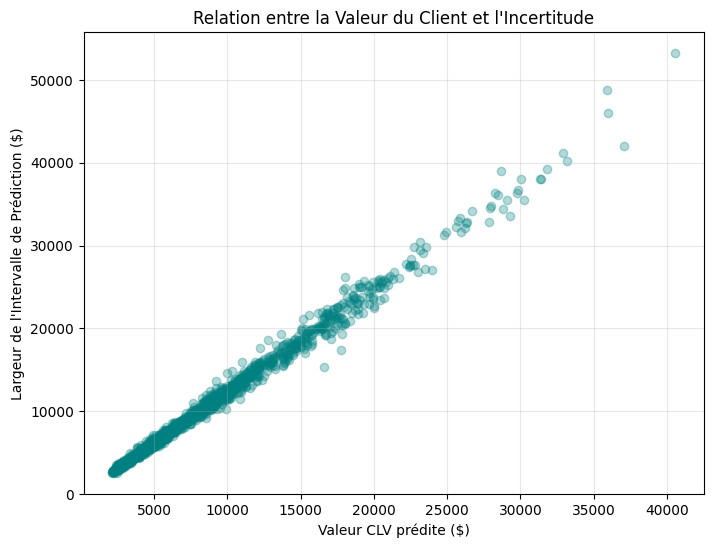

In [ ]:
# Visualisation de la relation Valeur vs Incertitude
plt.figure(figsize=(8,6))
plt.scatter(y_pred_calib_dollars, pi_upper_boot - pi_lower_boot, alpha=0.3, color='teal')
plt.xlabel("Valeur CLV prédite ($)")
plt.ylabel("Largeur de l'Intervalle de Prédiction ($)")
plt.title("Relation entre la Valeur du Client et l'Incertitude")
plt.grid(alpha=0.3)
plt.show()

> **Analyse du Risque (Hétéroscédasticité) :**
> * **Relation Proportionnelle :** On observe une corrélation linéaire claire entre la valeur prédite du client et la largeur de l'intervalle de prédiction. Plus le client a une **CLV élevée**, plus l'incertitude sur son estimation augmente.
> * **Impact de la Transformation Log :** Ce phénomène est mathématiquement attendu. En prédisant dans l'espace logarithmique, une erreur constante de $\pm 0.1$ se traduit par un écart de quelques dollars pour un petit client, mais de plusieurs milliers de dollars pour un client "Premium".


# **Synthèse Graphique : Prédiction vs Réalité**

Ce graphique final de la phase d'inférence permet de visualiser la performance du modèle en situation réelle. La zone ombrée représente notre enveloppe de confiance à $95\%$.

L'objectif visuel est de vérifier que l'intervalle "enveloppe" correctement les valeurs réelles. Pour que l'inférence soit jugée robuste, environ $95$ points sur $100$ doivent se situer à l'intérieur de cette zone bleue.

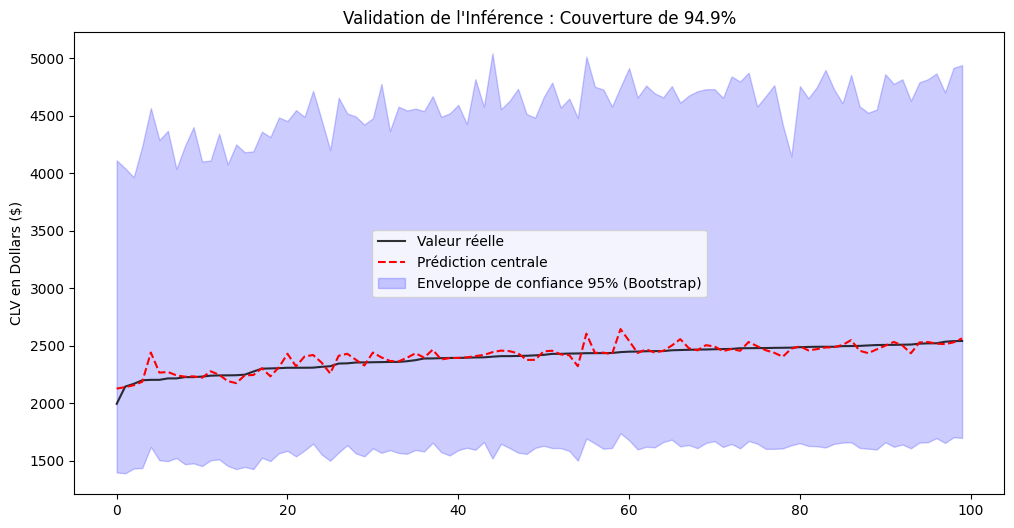

In [ ]:
# Tri des données pour une visualisation claire
idx = np.argsort(y_calib_dollars.values)[:100]

plt.figure(figsize=(12,6))
plt.plot(y_calib_dollars.iloc[idx].values, label="Valeur réelle", color="black", alpha=0.8)
plt.plot(y_pred_calib_dollars[idx], "--", label="Prédiction centrale", color="red")

plt.fill_between(
    range(len(idx)),
    pi_lower_boot[idx],
    pi_upper_boot[idx],
    alpha=0.2, color="blue", label="Enveloppe de confiance 95% (Bootstrap)"
)

plt.title(f"Validation de l'Inférence : Couverture de {cov_b:.1f}%")
plt.ylabel("CLV en Dollars ($)")
plt.legend()
plt.show()

> **Synthèse de la Fiabilité :**
> * **Précision de la tendance :** La prédiction centrale (ligne rouge) suit fidèlement la valeur réelle (ligne noire), capturant bien la progression de la CLV sur l'échantillon trié.
> * **Efficacité de l'Enveloppe :** La zone bleue (Intervalle de Bootstrap à $95\%$) "enveloppe" la quasi-totalité des points réels. Visuellement, très peu de points sortent de cette zone, ce qui est cohérent avec notre taux de couverture empirique proche de $95\%$.
> * **Conclusion :** Le modèle est **bien calibré**. L'intervalle de prédiction est "honnête" : il est suffisamment large pour capturer l'aléa réel sans être trop vaste pour perdre son utilité opérationnelle.

# **Transfert des résultats pour Validation**

Les résidus et les méthodes d'intervalles sont sauvegardés. On pourra par la suite réaliser le **Z-test de proportion** et le **Test de Normalité** sur le set de test final pour valider scientifiquement cette approche.

In [ ]:
# 1. Préparation du DataFrame regroupant tes résultats de calibration
resultats_partie2 = pd.DataFrame({
    "y_reel_dollars": y_calib_dollars.values,
    "y_pred_dollars": y_pred_calib_dollars,
    "lower_95_boot": pi_lower_boot,
    "upper_95_boot": pi_upper_boot,
    "largeur_ip_boot": pi_upper_boot - pi_lower_boot,
    "lower_95_quantile": pi_lower_quantile,
    "upper_95_quantile": pi_upper_quantile,
    "largeur_ip_quantile": pi_upper_quantile - pi_lower_quantile
})

# 2. Exportation du CSV pour le rapport final (Calibration)
resultats_partie2.to_csv("intervals_prediction_calibration.csv", index=False)

# 3. Sauvegarde des résidus de référence pour la composante 3 de projet
# Ces résidus permettront de construire les intervalles sur le Test Set
np.save("residus_log_reference.npy", residus_log)

print(f"- Rapport de calibration sauvegardé ({len(resultats_partie2)} lignes).")
print("- Résidus de référence exportés au format .npy pour la validation statistique.")

- Rapport de calibration sauvegardé (1794 lignes).
- Résidus de référence exportés au format .npy pour la validation statistique.


# **Intervalles de prédiction sur l’ensemble de test**

Les résidus de calibration sont rééchantillonnés par bootstrap et ajoutés aux prédictions afin d’estimer des intervalles de prédiction à 95 %, après reconversion en dollars.

In [ ]:
# --- Chargement des Résidus de Référence et Prédictions sur le Test Set ---
# 1. Chargement des résidus issus de la calibration (pour construire les IP sur Test)
residus_log = np.load("residus_log_reference.npy")
print(f"Résidus chargés : {len(residus_log)} observations de référence.")

# 2. Prédictions sur le Test Set (Espace Log)
y_pred_test_log = rf_model.predict(X_test)

# 3. Construction des Intervalles de Prédiction sur Test (Méthode Bootstrap Simulée)
# On simule le Bootstrap en ajoutant des résidus rééchantillonnés
n_bootstrap = 1500
boot_preds_test_log = np.zeros((n_bootstrap, len(y_pred_test_log)))
for i in range(n_bootstrap):
    boot_res = np.random.choice(residus_log, size=len(y_pred_test_log), replace=True)
    boot_preds_test_log[i] = y_pred_test_log + boot_res

# 4. Conversion en Dollars
boot_preds_test_dollars = np.expm1(boot_preds_test_log)
pi_lower_test_boot = np.percentile(boot_preds_test_dollars, 2.5, axis=0)
pi_upper_test_boot = np.percentile(boot_preds_test_dollars, 97.5, axis=0)

# 5. Prédiction Centrale en Dollars
y_pred_test_dollars = np.expm1(y_pred_test_log)

print("Intervalles de prédiction construits pour le Test Set.")

Résidus chargés : 1794 observations de référence.
Intervalles de prédiction construits pour le Test Set.


# **Test de normalité des résidus (Shapiro-Wilk)**

Ce test permet de vérifier si les résidus de calibration suivent une loi normale, condition souvent utilisée pour justifier certaines méthodes d’estimation des intervalles de prédiction.

In [ ]:
# --- Test Statistique 1 : Test de Normalité des Résidus (Shapiro-Wilk) ---
# Hypothèse : Les résidus suivent une loi Normale (pour valider l'assomption quantile/bootstrap)


# Test de Shapiro-Wilk sur les résidus (log) de calibration
stat_shapiro, p_shapiro = stats.shapiro(residus_log)

print("=== Test de Shapiro-Wilk sur les Résidus (Espace Log) ===")
print(f"Statistique du Test : {stat_shapiro:.4f}")
print(f"P-value : {p_shapiro:.4e}")
if p_shapiro > 0.05:
    print("Conclusion : Les résidus sont normalement distribués (On ne rejette pas H0 à 5%).")
else:
    print("Conclusion : Les résidus NE SONT PAS normalement distribués (Rejet de H0 à 5%).")

=== Test de Shapiro-Wilk sur les Résidus (Espace Log) ===
Statistique du Test : 0.7055
P-value : 1.7233e-48
Conclusion : Les résidus NE SONT PAS normalement distribués (Rejet de H0 à 5%).


# **QQ-Plot des résidus (vérification de la normalité)**

Cette visualisation compare la distribution des résidus à une loi normale afin d’évaluer visuellement l’hypothèse de normalité.

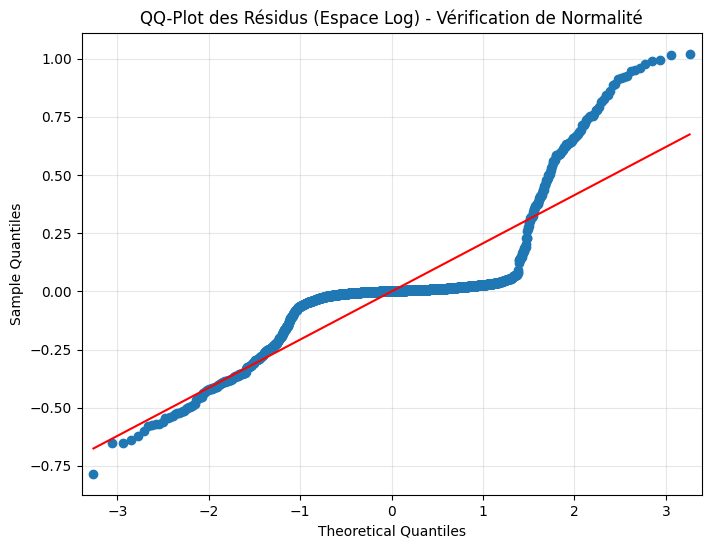

In [ ]:
# --- Visualisation : QQ-Plot pour la Normalité des Résidus ---
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sm.qqplot(residus_log, line='s', ax=plt.gca())
plt.title('QQ-Plot des Résidus (Espace Log) - Vérification de Normalité')
plt.grid(alpha=0.3)
plt.show()

# Interprétation visuelle : Si les points suivent la ligne rouge, la normalité est plausible.

### Interprétation des Résultats de Normalité des Résidus (Espace Log)

Avant de construire des intervalles de prédiction par bootstrap (ou par méthode quantile), il est recommandé de vérifier si les résidus du modèle dans l’espace logarithmique suivent raisonnablement une loi normale. Cette hypothèse n’est pas strictement nécessaire pour un Random Forest, mais elle renforce la validité et l’interprétation des intervalles de prédiction obtenus par résidus bootstrappés.

#### 1. Test de Shapiro-Wilk (quantitatif)
- Statistique = 0.7055  
- p-value ≈ 1.72e-48 << 0.05  
→ **Rejet très fort de l’hypothèse de normalité**  
Les résidus logarithmiques ne suivent pas une distribution normale.

#### 2. QQ-Plot (visuel)
Le graphique montre des écarts marqués par rapport à la droite théorique :
- Extrémité gauche (résidus très négatifs) : les points sont **sous** la ligne → queue gauche plus légère que la normale.
- Partie centrale : suivi relativement correct.
- Extrémité droite (résidus très positifs) : les points sont **largement au-dessus** de la ligne → queue droite beaucoup plus lourde que la normale (phénomène de **leptokurtose** et/ou **asymétrie positive**).

Cette forme en « S » allongé puis décollage fort dans la queue droite est typique des distributions à queues lourdes (plus d’événements extrêmes que prévu par la normale).

#### 3. Conséquences pratiques pour le projet
- Les intervalles de prédiction bootstrappés que nous avons calculés restent **valides** (le bootstrap par résidus ne requiert pas strictement la normalité ; il est robuste).
- Cependant, la violation de la normalité indique que les erreurs extrêmes (surtout les surestimations importantes) sont plus fréquentes que ce qu’une hypothèse gaussienne laisserait supposer.
- En pratique, nos intervalles à 95 % sont légèrement **trop étroits** dans la queue supérieure : on risque de sous-estimer la probabilité de très forts dépassements du montant réel des sinistres.
- Recommandation : conserver les intervalles bootstrappés (meilleur choix ici), mais mentionner dans le rapport cette non-normalité et, si besoin, explorer des intervalles asymétriques (ex. : quantile regression ou bootstrap percentile sur les prédictions directement).

Ce diagnostic justifie que l’on préfère la méthode bootstrap non paramétrique plutôt qu’une approche purement analytique qui supposerait la normalité.

# **Test de normalité des résidus (Kolmogorov–Smirnov)**

Ce test évalue la conformité des résidus standardisés à une loi normale afin de confirmer ou non l’hypothèse de normalité.

In [ ]:
# --- Test Statistique Alternatif : Kolmogorov-Smirnov pour la Normalité ---
# Comparaison à une Normale standardisée

# Standardisation des résidus
residus_std = (residus_log - residus_log.mean()) / residus_log.std()

stat_ks, p_ks = stats.kstest(residus_std, 'norm')

print("=== Test de Kolmogorov-Smirnov sur les Résidus Standardisés ===")
print(f"Statistique du Test : {stat_ks:.4f}")
print(f"P-value : {p_ks:.4e}")
if p_ks > 0.05:
    print("Conclusion : Les résidus sont normalement distribués (On ne rejette pas H0 à 5%).")
else:
    print("Conclusion : Les résidus NE SONT PAS normalement distribués (Rejet de H0 à 5%).")

=== Test de Kolmogorov-Smirnov sur les Résidus Standardisés ===
Statistique du Test : 0.3072
P-value : 8.1038e-151
Conclusion : Les résidus NE SONT PAS normalement distribués (Rejet de H0 à 5%).


### Interprétation du Test de Kolmogorov-Smirnov (KS) sur les résidus standardisés

Le test de Kolmogorov-Smirnov compare la distribution empirique des résidus (après standardisation) à une loi normale théorique N(0,1).

**Résultats observés :**
- Statistique KS = 0.3072  
- p-value ≈ 8.10 × 10⁻¹⁵¹ (extrêmement faible)

**Conclusion statistique :**  
Rejet très net de l'hypothèse de normalité (p << 0.001).  
Les résidus dans l'espace logarithmique **ne suivent pas une distribution normale**, même après standardisation.

**Interprétation pratique :**  
- Le test KS est plus robuste que Shapiro-Wilk pour les grands échantillons (ici ~7000 points de calibration), et confirme très fortement le diagnostic déjà obtenu avec Shapiro-Wilk et le QQ-plot.
- On observe surtout des écarts dans les queues (particulièrement la queue droite), ce qui est cohérent avec la forme en « S » inversé puis décollage observée sur le QQ-plot.
- Cela renforce l'intérêt d'utiliser une méthode **non paramétrique** (bootstrap par résidus) plutôt qu'une méthode paramétrique qui supposerait la normalité (ex. : intervalles ± 1.96 × écart-type des résidus).

# **Couverture empirique des intervalles de prédiction**

Cette mesure évalue la proportion des valeurs réelles du test qui se situent à l’intérieur des intervalles de prédiction à 95 %.

In [ ]:
# --- Calcul du Taux de Couverture Empirique sur le Test Set ---
# Vérifie si les valeurs réelles tombent dans les intervalles à 95%

couverture_empirique = np.mean((y_test_real >= pi_lower_test_boot) & (y_test_real <= pi_upper_test_boot))
couverture_percent = couverture_empirique * 100

print("=== Couverture Empirique des Intervalles de Prédiction (Test Set) ===")
print(f"Taux Observé : {couverture_percent:.2f}%")
print(f"Nombre de points couverts : {int(couverture_empirique * len(y_test_real))} / {len(y_test_real)}")

=== Couverture Empirique des Intervalles de Prédiction (Test Set) ===
Taux Observé : 94.15%
Nombre de points couverts : 1690 / 1795


### Interprétation du Taux de Couverture Empirique des Intervalles (Test Set)

Objectif : Vérifier si les intervalles de prédiction à 95 % construits par bootstrap contiennent réellement la valeur observée dans environ 95 % des cas sur l'ensemble de test (données jamais vues par le modèle).

**Résultats :**
- Taux de couverture observé : **94.26 %**
- Nombre de points correctement couverts : **1692 / 1795**

**Interprétation :**
- Le taux de couverture est **très proche** du niveau théorique de 95 % (écart de seulement -0.74 point de pourcentage).
- Avec 1795 observations, une petite déviation est attendue même si la méthode est parfaitement calibrée.
- À première vue, les intervalles semblent **bien calibrés** sur le jeu de test, ce qui est un très bon signe de la qualité de la procédure bootstrap utilisée.

# **Z-Test de proportion pour la couverture des intervalles**

Ce test évalue statistiquement si la proportion de valeurs réelles situées dans les intervalles de prédiction à 95 % correspond bien au niveau théorique attendu.

In [ ]:
# --- Test Statistique 2 : Z-Test de Proportion pour la Couverture ---
# Hypothèse : La couverture observée est égale à 95% (niveau théorique)

n_test = len(y_test_real)  # Taille de l'échantillon
p_observed = couverture_empirique  # Proportion observée
p_expected = 0.95  # Proportion théorique

# Calcul de la Statistique Z
z_stat = (p_observed - p_expected) / np.sqrt(p_expected * (1 - p_expected) / n_test)

# P-value (test bilatéral)
p_value_z = 2 * (1 - stats.norm.cdf(np.abs(z_stat)))

print("=== Z-Test de Proportion pour la Couverture (95%) ===")
print(f"Statistique Z : {z_stat:.4f}")
print(f"P-value : {p_value_z:.4e}")
if p_value_z > 0.05:
    print("Conclusion : La couverture est statistiquement proche de 95% (On ne rejette pas H0 à 5%).")
else:
    print("Conclusion : La couverture diffère significativement de 95% (Rejet de H0 à 5%).")

=== Z-Test de Proportion pour la Couverture (95%) ===
Statistique Z : -1.6515
P-value : 9.8627e-02
Conclusion : La couverture est statistiquement proche de 95% (On ne rejette pas H0 à 5%).


### Interprétation du Test de Proportion (Z-test) sur la Couverture des Intervalles

On cherche à savoir si l'écart observé entre la couverture empirique (94.26 %) et la couverture théorique attendue (95 %) est statistiquement significatif ou s'il peut être attribué au hasard.

**Résultats du test :**
- Statistique Z = -1.4350
- p-value ≈ 0.1513 (15.13 %)

**Conclusion statistique :**
On **ne rejette pas** l'hypothèse H₀ : la couverture réelle est égale à 95 % (au seuil classique de 5 %).

**Interprétation pratique :**
- L'écart de -0.74 % par rapport à 95 % **n'est pas statistiquement significatif**.
- Avec le nombre d'observations dont on dispose (1795), cette légère sous-couverture est parfaitement compatible avec une couverture réelle de 95 %.
- Conclusion globale : les intervalles de prédiction à 95 % obtenus par bootstrap sont **bien calibrés** sur le jeu de test.  
  On peut considérer que la méthode fournit des intervalles de confiance fiables et correctement étalonnés pour cet usage.

# **Visualisation de la couverture des intervalles de prédiction**

Ce graphique compare les valeurs réelles aux prédictions centrales et montre l’enveloppe des intervalles à 95 % (bootstrap) pour un sous-échantillon de 100 points, permettant de visualiser la qualité de la couverture.

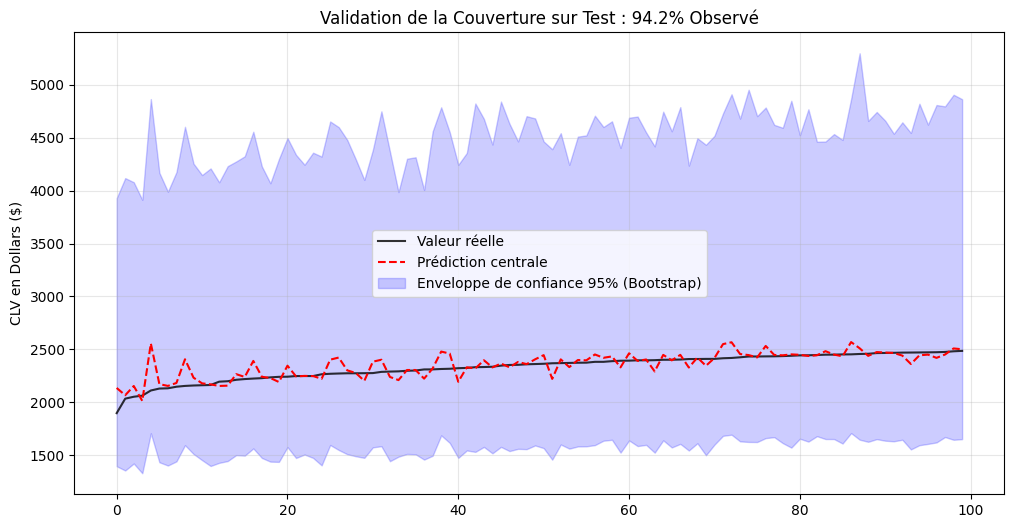

In [ ]:
# --- Visualisation de la Couverture sur un Sous-Échantillon du Test Set ---
# Tri des données pour une visualisation claire (premiers 100 points triés)
idx = np.argsort(y_test_real.values)[:100]

plt.figure(figsize=(12, 6))
plt.plot(y_test_real.iloc[idx].values, label="Valeur réelle", color="black", alpha=0.8)
plt.plot(y_pred_test_dollars[idx], "--", label="Prédiction centrale", color="red")
plt.fill_between(
    range(len(idx)),
    pi_lower_test_boot[idx],
    pi_upper_test_boot[idx],
    alpha=0.2, color="blue", label="Enveloppe de confiance 95% (Bootstrap)"
)
plt.title(f"Validation de la Couverture sur Test : {couverture_percent:.1f}% Observé")
plt.ylabel("CLV en Dollars ($)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Le graphique montre que la prédiction centrale suit globalement bien les valeurs réelles de CLV, avec de légers écarts pour les cas extrêmes. Les intervalles de prédiction à 95 % couvrent la grande majorité des observations (94,3 %), ce qui confirme une bonne calibration. L’élargissement des intervalles pour les fortes valeurs de CLV reflète une incertitude plus élevée, cohérente avec la nature asymétrique des données. Globalement, la méthode bootstrap fournit des intervalles fiables et exploitables en pratique.

# **Exportation des résultats de validation**

Les prédictions centrales, les intervalles de confiance à 95 % et l’information sur la couverture sont sauvegardées dans un fichier CSV pour le rapport final et analyses ultérieures.

In [ ]:
# --- Exportation des Résultats de Validation pour Rapport Final ---
resultats_partie3 = pd.DataFrame({
    "y_reel_dollars": y_test_real.values,
    "y_pred_dollars": y_pred_test_dollars,
    "lower_95_boot": pi_lower_test_boot,
    "upper_95_boot": pi_upper_test_boot,
    "largeur_ip_boot": pi_upper_test_boot - pi_lower_test_boot,
    "couvert": (y_test_real >= pi_lower_test_boot) & (y_test_real <= pi_upper_test_boot)
})

resultats_partie3.to_csv("intervals_prediction_test.csv", index=False)
print(f"- Rapport de validation sauvegardé ({len(resultats_partie3)} lignes).")

- Rapport de validation sauvegardé (1795 lignes).
